# Dataset Construction and Preparation

# This notebook is dedicated to the process of data preparation. <br>
It involves loading the dataset, identifying and handling any missing values, and conducting preliminary exploratory data analysis (EDA) to better understand the structure and characteristics of the data prior to applying sentiment analysis techniques.

<br>Preparing Stock Price Data (SPX_clean.csv)</br>

Load data: Historical OHLCV (Open, High, Low, Close, Volume) data is pulled from Yahoo Finance.

Clean data:

Fill missing values (e.g., holidays/weekends → forward-fill).

Remove dates with no trading activity.

Split data: Into 80% training, 10% validation, and 10% test sets.

80% ensures enough sequences for the LSTM to learn.

Validation fine-tunes hyperparameters.

Test remains unseen for final evaluation.

Normalize data: Using MinMaxScaler (0–1 range), to stabilize LSTM training.

Create sliding windows: Sequences of past n days (e.g., 10) are used to predict the next day’s closing price.




<br>Preparing News Headlines Data (combined.csv)</br>

Load dataset: Headlines from CNBC, Guardian, Reuters.

Preprocess text:

Lowercasing

Removing punctuation, stop words, HTML tags, duplicate headlines

Label sentiment: FinVADER used to generate weak-supervised labels (5 classes: Very Negative → Very Positive).

Align with stock data:

Headlines on non-trading days (weekends, holidays) are aggregated forward to the next trading day.

Weighted average sentiment is computed to represent that day.

Example: Headlines on Dec 30–31, 2017 rolled into Jan 2, 2018 (the next trading day).

Split dataset: Headlines split into training/validation/test based on stock price split ranges, ensuring that test data aligns with stock test data.



In [ ]:
from finvader import finvader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## News Headlines Data

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool specifically designed to capture the nuances of sentiment in social media contexts. Developed to process short, informal, and often noisy textual data such as tweets and online comments, VADER leverages a general purpose, human curated sentiment lexicon. This lexicon encompasses a wide range of linguistic features typical of social media, including emoticons, slang, acronyms, and punctuation-based emphasis (e.g., exclamation marks, capitalization).<br>

While VADER performs robustly on general-language data, its effectiveness diminishes when applied to domain-specific texts, such as those in the financial or economic sectors. This is primarily because VADER’s original lexicon lacks the specialized vocabulary and contextual sentiment orientations inherent in those fields. Consequently, financial texts often laden with industry-specific terminology and subtle sentiment cues can lead to inaccurate sentiment predictions when analyzed with the standard VADER model.<br>

To address this limitation, VADER can be fine-tuned for domain-specific applications by augmenting its lexicon with terms relevant to a particular field, along with corresponding sentiment polarity scores. The sentiment analysis process involves aggregating the sentiment values of individual tokens (words or symbols) in a given text. These values are then used to compute various sentiment scores: positive, negative, neutral, and a compound score. The compound score, a normalized aggregate of all token sentiment scores, ranges between -1 (extremely negative) and +1 (extremely positive), offering a more holistic view of overall sentiment.<br>

FinVADER is a specialized adaptation of the VADER sentiment analysis tool, tailored specifically for the financial domain. It incorporates domain-specific lexicons to enhance accuracy in financial text interpretation. Notably, FinVADER integrates two comprehensive finance-oriented word lists:<br>

SentiBignomics, a large-scale lexicon designed for aspect-based financial sentiment analysis. It contains approximately 7,300 finance-related terms, each assigned a sentiment polarity score within the range [-1, 1]. This lexicon supports fine-grained sentiment classification in financial documents, such as analyst reports or financial news.<br>

Henry’s Lexicon, which comprises 189 sentiment-bearing words commonly found in corporate earnings press releases. This lexicon was originally constructed for empirical finance research and is particularly effective for analyzing firm-specific communications.<br>

By incorporating these two finance focused lexicons, FinVADER significantly improves the reliability of sentiment analysis in financial contexts. It enables more accurate interpretation of textual data such as earnings announcements, market commentary, and investor communications areas where traditional sentiment analysis tools like the original VADER might underperform due to their general-purpose design.<br>


In the application of FinVADER for sentiment analysis on financial news headlines, pre-processing is intentionally omitted, and this methodological choice is both deliberate and justified by several linguistic and technical considerations. Unlike many Natural Language Processing (NLP) tasks that benefit from extensive text normalization, FinVADER relies on the raw input to retain syntactic and semantic cues that influence sentiment intensity and polarity. The decision not to pre-process the headlines prior to sentiment scoring is grounded in the following reasons:<br>

Concise Nature of Financial Headlines
Financial news headlines are typically brief, focused, and devoid of extraneous linguistic content. They are designed to deliver key information succinctly, often omitting stopwords and unnecessary grammatical constructs. As a result, standard pre-processing techniques such as token removal, lowercasing, or lemmatization may not yield significant improvements and could, in fact, reduce the fidelity of sentiment cues.<br>

Punctuation as an Indicator of Sentiment Intensity
VADER is designed to interpret punctuation marks particularly exclamation points as modifiers of emotional intensity. For instance, the phrases “I am happy” and “I am happy!!!” convey differing degrees of positivity, which VADER is equipped to quantify. Removing punctuation during pre-processing would therefore obscure such sentiment signals, leading to less accurate predictions.<br>

Capitalization as an Emphasis Mechanism
The use of uppercase letters in text (e.g., “I AM HAPPY”) serves as a proxy for emotional emphasis or shouting. VADER accounts for capitalization when determining sentiment strength. Normalizing all text to lowercase would eliminate this important paralinguistic cue and result in sentiment scores that are less reflective of the true emotional tone.<br>

Degree Modifiers and Sentiment Amplification
Words such as “very”, “extremely”, or “somewhat” function as degree modifiers that either amplify or dampen the sentiment conveyed by adjacent terms. For example, “I am extremely happy” denotes a stronger sentiment than “I am happy”. FinVADER recognizes and adjusts sentiment scores based on these modifiers, which could be lost or misinterpreted if the text were simplified during pre-processing.<br>

Sentiment Reversers and Conjunctions
Lexical constructs like “but” play a pivotal role in altering sentiment orientation. For example, the statement “I am happy but sad” places emphasis on the latter emotion, whereas “I am happy and sad” suggests a more balanced sentiment. FinVADER uses rules to detect such conjunctions and shift sentiment polarity accordingly. Pre-processing that removes such words or restructures the sentence could disrupt this functionality.<br>

Negation and Tri-gram Contextual Analysis
One of VADER’s key innovations lies in its ability to detect negation and sentiment reversal through tri-gram analysis. This involves evaluating up to three tokens before a sentiment bearing word to determine if a negator (e.g., “not”, “never”) flips its polarity. For instance, “not good” would be scored negatively, in contrast to “good”. Pre-processing steps that reduce or alter such patterns may impair the model’s ability to interpret these nuanced expressions correctly.<br>

These capabilities highlight why VADER—and by extension, FinVADER is most effective when operating on unprocessed, original text. The tool’s design explicitly leverages lexical, grammatical, and paralinguistic features that are often removed in traditional NLP pipelines. Therefore, bypassing standard pre-processing aligns with best practices for achieving accurate and context-aware sentiment analysis in the financial domain.<br>

Source: Are You Scared, VADER? Understanding How NLP Pre-processing Impacts VADER Scoring <br>
https://towardsdatascience.com/are-you-scared-vader-understanding-how-nlp-pre-processing-impacts-vader-scoring-4f4edadbc91d



In [ ]:
# Read in the data from Reuters
df_reuters = pd.read_csv('reuters_headlines.csv')
df_reuters.head()

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...


In [ ]:
# Drop the 'Description' column
df_reuters = df_reuters[['Headlines', 'Time']]

# Drop the rows with missing values
df_reuters = df_reuters.dropna()

# Convert the 'time' column to 'yyyy-mm-dd' format
df_reuters['Time'] = pd.to_datetime(df_reuters['Time']).dt.strftime('%Y-%m-%d')

df_reuters['Headlines'] = df_reuters['Headlines'].str.replace('\n', '')
# remove the leading and trailing whitespaces
df_reuters['Headlines'] = df_reuters['Headlines'].str.strip()
# remove punctuations
df_reuters['Headlines'] = df_reuters['Headlines'].str.replace('[^\w\s]','')
# remove special characters
df_reuters['Headlines'] = df_reuters['Headlines'].str.replace(':', '')

# sort the dataframe by date
df_reuters.sort_values(by=['Time'], inplace=True, ascending=True)

df_reuters.reset_index(drop=True, inplace=True)

df_reuters.head()

,Headlines,Time
0,UK will always consider ways to improve data l...,2018-03-20
1,Senate Democrat wants Facebook CEO Zuckerberg ...,2018-03-20
2,"Factbox How United States, others regulate aut...",2018-03-20
3,Cambridge Analytica played key Trump campaign ...,2018-03-20
4,Start of AT&T-Time Warner trial delayed until ...,2018-03-20


In [ ]:
df_reuters['finvader'] = df_reuters['Headlines'].apply(
    finvader,
    use_sentibignomics=True,
    use_henry=True,
    indicator="compound")

df_reuters.head()

,Headlines,Time,Description,finvader
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,0.0000
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,0.0721
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,-0.2960
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,-0.2960
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,-0.3356


In [ ]:
df_cnbc = pd.read_csv('cnbc_headlines.csv')
df_cnbc.head()

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN,NaN,NaN
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."


In [ ]:
df_cnbc = df_cnbc[['Headlines', 'Time']]
# remove NaN values
df_cnbc.dropna(inplace=True)

# Convert the 'time' column to 'yyyy-mm-dd' format
df_cnbc['Time'] = pd.to_datetime(df_cnbc['Time']).dt.strftime('%Y-%m-%d')

df_cnbc['Headlines'] = df_cnbc['Headlines'].str.replace('\n', '')
# remove the leading and trailing whitespaces
df_cnbc['Headlines'] = df_cnbc['Headlines'].str.strip()
# remove punctuations
df_cnbc['Headlines'] = df_cnbc['Headlines'].str.replace('[^\w\s]','')
# remove special characters
df_cnbc['Headlines'] = df_cnbc['Headlines'].str.replace(':', '')
df_cnbc['Headlines'] = df_cnbc['Headlines'].str.replace('—', '')

df_cnbc = df_cnbc.sort_values('Time')

df_cnbc.reset_index(drop=True, inplace=True)

df_cnbc.head()

,Headlines,Time
0,Cramer Never buy a stock all at once you'll a...,2017-12-22
1,Cramer I helped investors through the 2010 fla...,2017-12-22
2,Cramer says owning too many stocks and too lit...,2017-12-22
3,Markets lack Christmas cheer,2017-12-26
4,S&P tends to start new year bullish after this...,2017-12-27


In [ ]:
df_cnbc['finvader'] = df_cnbc['Headlines'].apply(
    finvader,
    use_sentibignomics=True,
    use_henry=True,
    indicator="compound")

df_cnbc.head()

,Headlines,Time,finvader
0,Cramer Never buy a stock all at once you'll a...,2017-12-22,0.0090
1,Cramer I helped investors through the 2010 fla...,2017-12-22,-0.0207
2,Cramer says owning too many stocks and too lit...,2017-12-22,0.0232
3,Markets lack Christmas cheer,2017-12-26,0.0052
4,S&P tends to start new year bullish after this...,2017-12-27,-0.0013


In [ ]:
df_guardian = pd.read_csv('guardian_headlines.csv')
df_guardian.head()

,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
2,18-Jul-20,Five key areas Sunak must tackle to serve up e...
3,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,18-Jul-20,The Week in Patriarchy \n\n\n Bacardi's 'lad...


In [ ]:
df_guardian[['Headlines', 'Time']]

# remove NaN values
df_guardian.dropna(inplace=True)

# Convert the 'time' column to 'yyyy-mm-dd' format
df_guardian['Time'] = pd.to_datetime(df_guardian['Time'], errors='coerce').dt.strftime('%Y-%m-%d')
df_guardian.dropna(subset=['Time'], inplace=True)

# remove '\n' from the 'Headlines' column
df_guardian['Headlines'] = df_guardian['Headlines'].str.replace('\n', '')
# remove the leading and trailing whitespaces
df_guardian['Headlines'] = df_guardian['Headlines'].str.strip()
# remove punctuations
df_guardian['Headlines'] = df_guardian['Headlines'].str.replace('[^\w\s]','')
# remove special characters
df_guardian['Headlines'] = df_guardian['Headlines'].str.replace(':', '')
df_guardian['Headlines'] = df_guardian['Headlines'].str.replace('—', '')

df_guardian = df_guardian.sort_values('Time')

df_guardian.reset_index(drop=True, inplace=True)

df_guardian.head()

,Time,Headlines
0,2017-12-17,The Guardian view on Ryanair’s model a union-f...
1,2017-12-17,Peter Preston on press and broadcasting Pau...
2,2017-12-17,Why business could prosper under a Corbyn gove...
3,2017-12-17,Youngest staff to be given UK workplace pensio...
4,2017-12-17,Grogonomics This year has been about compan...


In [ ]:
df_guardian['finvader'] = df_guardian['Headlines'].apply(
    finvader,
    use_sentibignomics=True,
    use_henry=True,
    indicator="compound")

df_guardian.head()

,Time,Headlines,finvader
0,2017-12-17,The Guardian view on Ryanair’s model a union-f...,0.0000
1,2017-12-17,Peter Preston on press and broadcasting Pau...,0.3612
2,2017-12-17,Why business could prosper under a Corbyn gove...,-0.3400
3,2017-12-17,Youngest staff to be given UK workplace pensio...,-0.1921
4,2017-12-17,Grogonomics This year has been about compan...,0.0000


In [ ]:
print(df_reuters['Time'].min())
print(df_reuters['Time'].max())
print(df_reuters.count())
print()
print(df_cnbc['Time'].min())
print(df_cnbc['Time'].max())
print(df_cnbc.count())
print()
print(df_guardian['Time'].min())
print(df_guardian['Time'].max())
print(df_guardian.count())

Apr 01 2018
Sep 30 2019
Headlines      32770
Time           32770
Description    32770
finvader       32770
dtype: int64

2017-12-22
2020-07-17
Headlines    2800
Time         2800
finvader     2800
dtype: int64

2017-12-17
2020-07-18
Time         17760
Headlines    17760
finvader     17760
dtype: int64


In [ ]:
# combine the 3 news headlines dataframes from Reuters, CNBC, and The Guardian
df = pd.concat([df_reuters, df_cnbc, df_guardian], ignore_index=True)

# add a new column 'Source' to the dataframe
df['Source'] = pd.concat([pd.Series(['Reuters']*len(df_reuters)), pd.Series(['CNBC']*len(df_cnbc)), pd.Series(['Guardian']*len(df_guardian))], ignore_index=True)

# sort the dataframe by date
df = df.sort_values('Time')

# round the finvader score to 2 decimal places
df['finvader_rounded'] = df['finvader'].apply(lambda x: round(x, 1))

# reset the index
df.reset_index(drop=True, inplace=True)

df.head()

,Headlines,Time,Description,finvader,Source,finvader_rounded
0,"Uber stole trade secrets, bribed foreign offic...",2017-12-17,NaN,0.0717,Guardian,0.1
1,‘Going to the Furniture Ombudsman about our so...,2017-12-17,NaN,-0.0116,Guardian,-0.0
2,Hundreds to lose jobs as Britvic shuts down No...,2017-12-17,NaN,-0.3716,Guardian,-0.4
3,Alabama unions see Doug Jones's win as a victo...,2017-12-17,NaN,0.0567,Guardian,0.1
4,Poundland suppliers hit by insurance downgrade,2017-12-17,NaN,-0.0284,Guardian,-0.0


In [ ]:
conditions = [
    df['finvader_rounded'] > 0.5,
    (df['finvader_rounded'] > 0) & (df['finvader_rounded'] <= 0.5),
    df['finvader_rounded'] == 0,
    (df['finvader_rounded'] < 0) & (df['finvader_rounded'] >= -0.5)
]

choices = [
    4,
    3,
    2,
    1
]

df['Label'] = np.select(conditions, choices, default=0)
df.head()

,Headlines,Time,Description,finvader,Source,finvader_rounded,Label
0,"Uber stole trade secrets, bribed foreign offic...",2017-12-17,NaN,0.0717,Guardian,0.1,3
1,‘Going to the Furniture Ombudsman about our so...,2017-12-17,NaN,-0.0116,Guardian,-0.0,2
2,Hundreds to lose jobs as Britvic shuts down No...,2017-12-17,NaN,-0.3716,Guardian,-0.4,1
3,Alabama unions see Doug Jones's win as a victo...,2017-12-17,NaN,0.0567,Guardian,0.1,3
4,Poundland suppliers hit by insurance downgrade,2017-12-17,NaN,-0.0284,Guardian,-0.0,2


In [ ]:
df['Label'].value_counts()

Label
2    26779
1    12576
3    10412
0     1892
4     1671
Name: count, dtype: int64

In [ ]:
df.to_csv('combined2.csv', index=False)

## Stock Market Data

The stock price data and the sentiment scores generated using the FinVADER sentiment analysis tool are integrated to form a comprehensive dataset for training a stock price prediction model. This combined dataset captures both quantitative financial indicators and qualitative sentiment cues, enabling a more holistic approach to forecasting market movements.<br>

The predictive model employed is a Long Short-Term Memory (LSTM) neural network, which is well-suited for modeling sequential and time-dependent data. The LSTM model takes as input a series of features, including historical stock prices and corresponding FinVADER sentiment scores (e.g., positive, negative, neutral, and compound scores), to learn patterns and dependencies over time. The goal of the model is to predict future stock prices by leveraging both market trends and sentiment dynamics derived from financial news headlines.

We begin by importing the S&P 500 Index (SPX) historical price data, <br>
which has been previously downloaded from Yahoo Finance. <br>
This dataset provides time-series data on key financial indicators such as opening price, closing price, high, low, volume, and adjusted close. <br>
It will serve as the foundational input for the stock price prediction model and be later aligned with sentiment scores derived from financial news headlines.

In [ ]:
# load the S&P 500 stock price dataset
df_time_series = pd.read_csv('SPX.csv')
# show top 5 rows
df_time_series.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,2685.919922,2694.969971,2685.919922,2690.159912,2690.159912,3727770000
1,2017-12-19,2692.709961,2694.439941,2680.739990,2681.469971,2681.469971,3407680000
2,2017-12-20,2688.179932,2691.010010,2676.110107,2679.250000,2679.250000,3246230000
3,2017-12-21,2683.020020,2692.639893,2682.399902,2684.570068,2684.570068,3293130000
4,2017-12-22,2684.219971,2685.350098,2678.129883,2683.340088,2683.340088,2401030000


we remove all non essential columns that do not contribute meaningfully to the stock price prediction task. <br>
Typically, this involves retaining only the most relevant features such as the 'Close' or 'Adjusted Close' <br>

prices while discarding auxiliary columns like 'Open', 'High', 'Low', and 'Volume', unless they are explicitly required for model input. <br>
This step helps reduce dimensionality and improves model efficiency by focusing solely on predictive features.<br>

Stock prices are cleaned, scaled, and windowed.

Headlines are cleaned, sentiment-labeled, and aligned.

Both datasets are merged with careful handling of dates.

Splits (train/val/test) are aligned across stock and headline data for consistent evaluation.<br>

In [ ]:
# drop unnecessary columns
df_time_series = df_time_series.drop(['Open', 'High', 'Low', 'Volume', 'Close'], axis=1)

# convert the 'Date' column to datetime format
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])

# show top 5 rows
df_time_series.head()

,Date,Adj Close
0,2017-12-18,2690.159912
1,2017-12-19,2681.469971
2,2017-12-20,2679.250000
3,2017-12-21,2684.570068
4,2017-12-22,2683.340088


In [ ]:
df_time_series.to_csv('SPX_clean.csv', index=False)

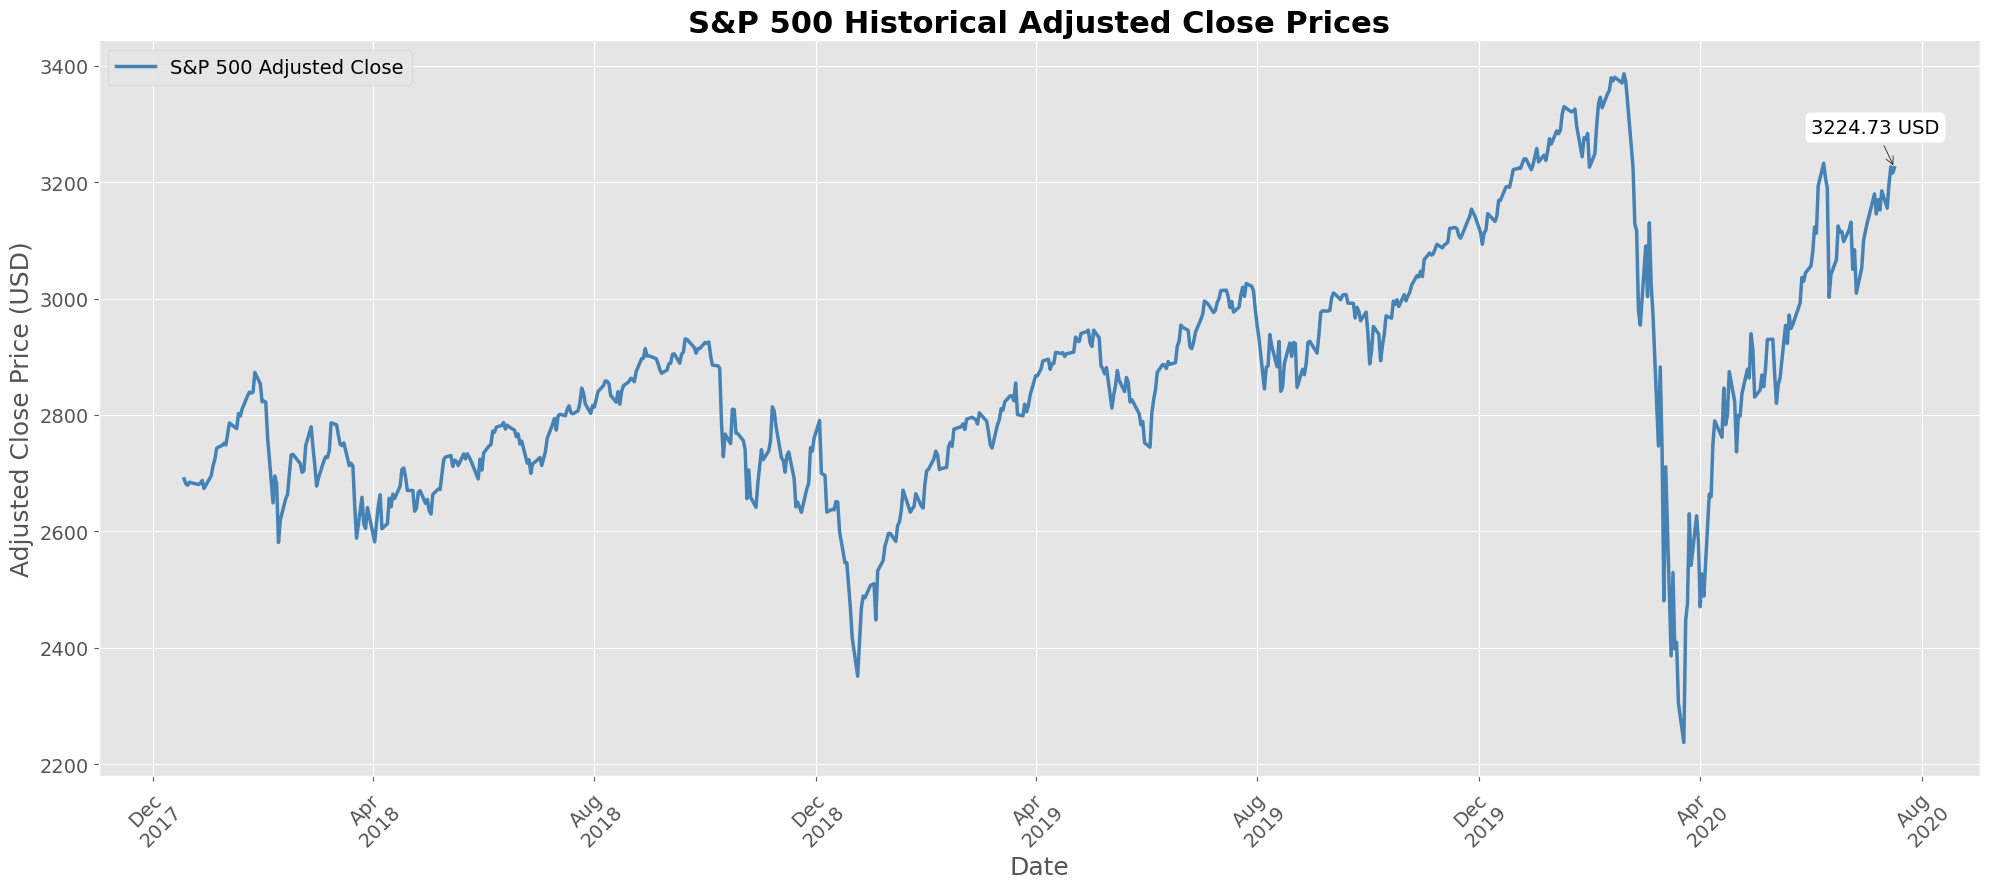

In [ ]:
# Ensure 'Date' column is datetime
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])

# Use a safe built-in style
plt.style.use('ggplot')  # reliable and clean for reports

# Create the plot
fig, ax = plt.subplots(figsize=(20, 9))

# Plot the stock price line
ax.plot(df_time_series['Date'], df_time_series['Adj Close'],
        color='steelblue', linewidth=2.5, label='S&P 500 Adjusted Close')

# Format x-axis with major ticks every 4 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Titles and labels
ax.set_title('S&P 500 Historical Adjusted Close Prices', fontsize=22, fontweight='bold')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Close Price (USD)', fontsize=18)

# Improve tick label sizes and rotation
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add annotation for the most recent point
latest_date = df_time_series['Date'].iloc[-1]
latest_price = df_time_series['Adj Close'].iloc[-1]
ax.annotate(f'{latest_price:.2f} USD',
            xy=(latest_date, latest_price),
            xytext=(-60, 25), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=14, bbox=dict(boxstyle='round,pad=0.3', facecolor='white'))

# Show legend
ax.legend(loc='upper left', fontsize=14)

# Final layout adjustments
plt.tight_layout()
plt.show()